<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread
import random 
import cv2
from numpy import asarray
random.seed(0)

from tensorflow.keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
import cv2

drive.mount('/content/drive')

Mounted at /content/drive


##Import data

In [2]:
#@title 
base = "/content/drive/MyDrive/Pneumonia/"
train_dir = base + "train/"
test_dir = base + "test/"
val_dir = base + "val/"

os.listdir(f'{train_dir}/NORMAL') 

def data_lookup(dir, label): 
  shape0, shape1 = [], [] #height, width
  files = os.listdir(os.path.join(dir, label))
  for image_file_name in files: 
    shape = (cv2.imread(os.path.join(os.path.join(dir, label), image_file_name)).shape)
    shape0.append(shape[0])
    shape1.append(shape[1])

  print(str(dir).split("/")[5].upper(),  label)
  print("number of images: ", len(files))
  print("width range: ", min(shape1),'-', max(shape1))
  print("height range: ", min(shape0),'-', max(shape0))
  print("No. channel of image: ", len(shape))
  print("=====================")

data_lookup(train_dir, "PNEUMONIA")
data_lookup(train_dir, "NORMAL")
data_lookup(test_dir, "PNEUMONIA")
data_lookup(test_dir, "NORMAL")
data_lookup(val_dir, "PNEUMONIA")
data_lookup(val_dir, "NORMAL")

TRAIN PNEUMONIA
number of images:  3933
width range:  384 - 2772
height range:  127 - 2304
No. channel of image:  3
TRAIN NORMAL
number of images:  1359
width range:  912 - 2916
height range:  672 - 2663
No. channel of image:  3
TEST PNEUMONIA
number of images:  390
width range:  728 - 2000
height range:  344 - 1456
No. channel of image:  3
TEST NORMAL
number of images:  234
width range:  984 - 2752
height range:  496 - 2713
No. channel of image:  3
VAL PNEUMONIA
number of images:  8
width range:  968 - 1664
height range:  592 - 1128
No. channel of image:  3
VAL NORMAL
number of images:  8
width range:  1240 - 1776
height range:  928 - 1416
No. channel of image:  3


## Exploratory analysis

###charts
- pneumonia vs normal 
- pneumonia type (bacteria vs virus) pie chart

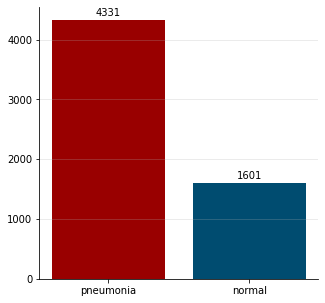

In [3]:
#@title 
total_num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))) + len(os.listdir(os.path.join(test_dir, 'PNEUMONIA'))) + len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
total_num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL'))) + len(os.listdir(os.path.join(test_dir, 'NORMAL'))) + len(os.listdir(os.path.join(val_dir, 'NORMAL')))

#bar-chart pneumonia vs normal 
fig, ax =  plt.subplots(figsize = (5, 5))
ax.bar(['pneumonia','normal'], [total_num_pneumonia, total_num_normal], color = ('#990000', '#004c70'))
for s in ["top","right"]:
    ax.spines[s].set_visible(False)

#annotate y-value
for bar in ax.patches: 
  ax.annotate(f"{bar.get_height():.0f}", 
                   xy = (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')

# y-axis tick
grid_y_ticks = np.arange(0, 4400, 1000)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y', linestyle='-', alpha=0.3)


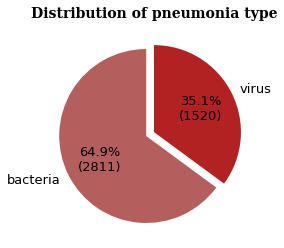

In [4]:
#@title 
total_pneumonia_filenames = os.listdir(os.path.join(train_dir, 'PNEUMONIA')) + os.listdir(os.path.join(test_dir, 'PNEUMONIA')) + os.listdir(os.path.join(val_dir, 'PNEUMONIA'))

virus_cnt, bacteria_cnt = 0, 0
for pneumonia_filename in total_pneumonia_filenames: 
  p_type = pneumonia_filename.split('_')[1]
  if p_type == "virus": 
    virus_cnt += 1
  elif p_type == "bacteria": 
    bacteria_cnt += 1
# print("total_pneumonia_cases: ", len(total_pneumonia_filenames))
# print("virus count: ", virus_cnt)
# print("bacteria count: ",bacteria_cnt)

#distribution of pneumonia type - pie chart
y = [bacteria_cnt, virus_cnt]
labels = ["bacteria", "virus"]
colors = ['#b55e5e','#b22222']
myexplode = [0.1, 0]
def prob(x): 
  return '{:.1f}'.format(x) + '%' + "\n" + '(' + '{:.0f}'.format(x/100 * 4331) + ')'

plt.title("Distribution of pneumonia type", fontsize=14, fontweight='bold', fontfamily='serif')
plt.pie(y, labels=labels, startangle=90, colors=colors, explode=myexplode, autopct=prob, textprops={'fontsize': 13})
plt.show()

##show images
- pneumonia images
- normal images

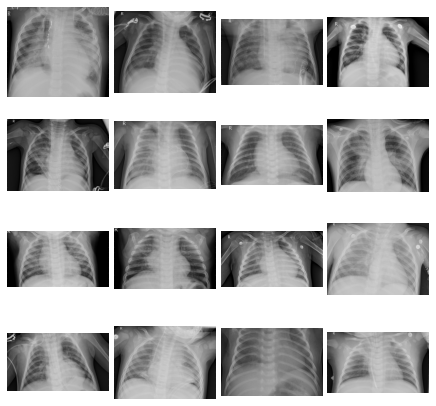

In [5]:
#@title
def show_images(dir, label, size): 
  image_names = os.listdir(os.path.join(dir, label))
  selected_images = random.sample(image_names, size*size) #random select 

  plt.figure(figsize=(6,6))
  for i in range(size*size): 
    plt.subplot(size, size, i + 1)
    image = cv2.imread(os.path.join(os.path.join(dir, label), selected_images[i]))
    plt.imshow(image)
    plt.axis('off')
  plt.tight_layout(pad=0.5)
show_images(train_dir, label="PNEUMONIA", size=4) #generate size * size image plot 

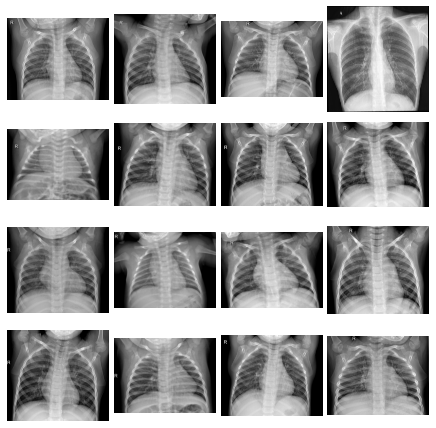

In [6]:
show_images(train_dir, label="NORMAL", size=4)

### Average image

In [7]:
#@title
def img_to_array(dir, label, size = (128,128)): #convert image to array to get mean pixel values
  image_array_list = []
  files = os.listdir(os.path.join(dir, label))
  for f in files: 
    file_path = os.path.join(os.path.join(dir, label), f)
    img = image.load_img(file_path, target_size = size, color_mode='grayscale')
    img_array = asarray(img).flatten()
    image_array_list.append(img_array)
  return image_array_list

p_imgs = img_to_array(train_dir, "PNEUMONIA")
n_imgs = img_to_array(train_dir, "NORMAL")

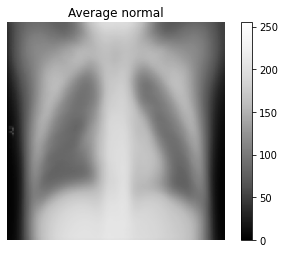

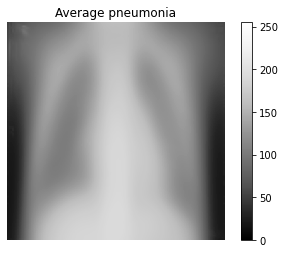

In [8]:
#@title
def average_img(images_list, label, size = (128,128)):
    # calculate the average
    avg_img = np.mean(images_list, axis = 0)
    # reshape
    avg_img = avg_img.reshape(size)
    plt.imshow(avg_img, cmap='Greys_r', vmin=0, vmax=255) 
    plt.title(f'Average {label.lower()}')
    plt.colorbar()
    plt.axis('off')
    plt.show()
    return avg_img

norm_mean = average_img(n_imgs, 'NORMAL')
pneu_mean = average_img(p_imgs, 'PNEUMONIA')
#pneumonia X-rays tend to show higher obstruction around the chest area.

###Contrast

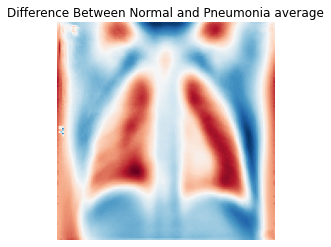

In [9]:
#@title
contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='RdBu')
plt.title(f'Difference Between Normal and Pneumonia average')
plt.axis('off')
plt.show()
#red indicates the most different areas in dark color 
#blue indicates the most different areas in light color 

### standard deviation 

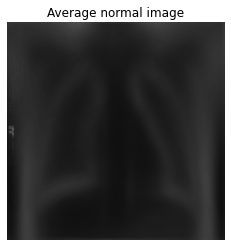

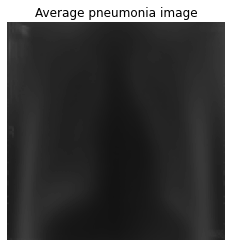

In [10]:
#@title
def std_img(images_list, label, size = (128,128)):
    # calculate the average
    avg_img = np.std(images_list, axis = 0)
    # reshape it back to a matrix
    avg_img = avg_img.reshape(size)
    plt.imshow(avg_img, cmap='gray', vmin=0, vmax=255) 
    plt.title(f'Average {label.lower()} image')
    plt.axis('off')
    plt.show()
    return avg_img

norm_std = std_img(n_imgs, 'NORMAL')
pneu_std = std_img(p_imgs, 'PNEUMONIA')

#there are larger areas of variance found in pneumonia lung 

In [11]:
# Eigenimages
# Lastly, we can use a dimension reduction technique such as the principal component analysis (PCA) to visualize the components that describe each class the best. The eigenimages, which is essentially the eigenvectors (components) of PCA of our image matrix, can be reshaped into a matrix and be plotted. It’s also called eigenfaces as this approach was first used for facial recognition research. Here we will visualize the principal components that describe 70% of variability for each class.
# https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

#Image preprocessing
- resize images
- Augmentation with or without

In [21]:
train_datagen = ImageDataGenerator(shear_range = 0.1,
                                   zoom_range = 0.1,
                                   rotation_range=15,
                                   horizontal_flip = True)
null_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()  

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_set = test_datagen.flow_from_directory(val_dir,
                                                  target_size=(64, 64),
                                                  batch_size=32,
                                                  class_mode='binary')

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 5292 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
#images to array 
def img_to_array(dir, label, img_size = 128): #separate for virus and bacteria in pneumonia class
  image_path = dir + str(label.upper()) #folder name is in upper case 
  image_files = os.listdir(os.path.join(train_dir, str(label.upper())))
  
  #converting pneumonia/normal images to array 
  images = []
  b_images, v_images = [], []
  for image_file in tqdm(image_files): 
    image = cv2.imread(os.path.join(image_path, image_file))
    image = cv2.resize(image, (img_size, img_size)) #SET IMAGE SIZE 
    image = image / 255. #NORMALIZE PIXEL VALUE
    images.append(image)

    if label == 'pneumonia': 
      if image_file.split('_')[1] == 'bacteria': 
        b_images.append(image)
      elif image_file.split('_')[1] == 'virus': 
        v_images.append(image)
    
  if label == 'normal': 
    return np.array(images)
  
  elif label == 'pneumonia': 
    return np.array(images), np.array(b_images), np.array(v_images)

#pneumonia images to three arrays: all pneumonia, bacteria, virus 
p_images, b_images, v_images = img_to_array(train_dir, 'pneumonia')
print("pneumonia:",p_images.shape, "bateria:", b_images.shape, "virus:",v_images.shape)

#normal image to an array
n_images = img_to_array(train_dir, 'normal')
print("normal: ", n_images.shape)

100%|██████████| 3933/3933 [00:46<00:00, 85.37it/s]


pneumonia: (3933, 128, 128, 3) bateria: (2561, 128, 128, 3) virus: (1372, 128, 128, 3)


100%|██████████| 1359/1359 [00:41<00:00, 33.07it/s]


normal:  (1359, 128, 128, 3)


In [35]:
#create folders for augmented images 
!rm -rf 'Augmented'
!mkdir 'Augmented'
!rm -rf 'Augmented/pneumonia'
!mkdir 'Augmented/pneumonia'
!rm -rf 'Augmented/normal'
!mkdir 'Augmented/normal'
!rm -rf 'Augmented/virus'
!mkdir 'Augmented/virus'
!rm -rf 'Augmented/bacteria'
!mkdir 'Augmented/bacteria'

In [36]:
#create folders for augmented images 
!rm -rf 'Non-augmented'
!mkdir 'Non-augmented'
!rm -rf 'Non-augmented/pneumonia'
!mkdir 'Non-augmented/pneumonia'
!rm -rf 'Non-augmented/normal'
!mkdir 'Non-augmented/normal'
!rm -rf 'Non-augmented/virus'
!mkdir 'Non-augmented/virus'
!rm -rf 'Non-augmented/bacteria'
!mkdir 'Non-augmented/bacteria'

In [37]:
#Augmented data into a folder 
#function for increasing image samples x times
#every epoch, the number of train_data is added
def x_times_data(epoch, datagen, train_data, label, folder): 
  i = 0 
  for batch in datagen.flow(train_data,  #파일 저장 말고  array 로 바로 바꾸는방법 찾기 *** 
                            batch_size = len(train_data),
                            save_to_dir = folder + '/' + label, 
                            save_format='jpg'):
    i += 1
    if i == epoch: 
      break

#increase 'pneumonia' training image x times 
x_times_data(1, train_datagen, p_images, 'pneumonia', 'Augmented')
print(len(os.listdir('Augmented/pneumonia')))
#increase 'pneumonia' training image x times 
x_times_data(3, train_datagen, n_images, 'normal', 'Augmented')
print(len(os.listdir('Augmented/normal')))

3933
4076


In [38]:
#Non-augmented (raw) data into a folder 
#raw pneumonia images 
x_times_data(1, null_datagen, p_images, 'pneumonia', 'Non-augmented')
print(len(os.listdir('Non-augmented/pneumonia')))
#raw normal images
x_times_data(1, null_datagen, n_images, 'normal', 'Non-augmented')
print(len(os.listdir('Non-augmented/normal')))
#raw bacteria images
x_times_data(1, null_datagen, b_images, 'bacteria', 'Non-augmented')
print(len(os.listdir('Non-augmented/bacteria')))
#raw virus images
x_times_data(1, null_datagen, v_images, 'virus', 'Non-augmented')
print(len(os.listdir('Non-augmented/virus')))

3933
1359
2561
1372


#Extra

In [ ]:
# #@title 
# #gathering pixel min, max, mean, std information in the training set 
# #pneumonia images from training set 
# p_dir = base + "train/PNEUMONIA/" 
# p_files = os.listdir(os.path.join(train_dir,'PNEUMONIA'))
# p_images_min, p_images_max, p_images_mean, p_images_std = [], [], [], []
# for p_file in tqdm(p_files): 
#   p_image = cv2.imread(os.path.join(p_dir, p_file))
#   p_images_min.append(int(p_image.min())) #int: round float to int 
#   p_images_max.append(int(p_image.max()))
#   p_images_mean.append(int(p_image.mean()))
#   p_images_std.append(int(p_image.std()))

# #normal images from training set 
# n_dir = base + "train/NORMAL/" 
# n_files = os.listdir(os.path.join(train_dir,'NORMAL'))
# n_images_min, n_images_max, n_images_mean, n_images_std = [], [], [], []
# for n_file in tqdm(n_files): 
#   n_image = cv2.imread(os.path.join(n_dir, n_file))
#   n_images_min.append(int(n_image.min())) #int: round float to int 
#   n_images_max.append(int(n_image.max()))
#   n_images_mean.append(int(n_image.mean()))
#   n_images_std.append(int(n_image.std()))

###pixel distribution

In [ ]:
# #@title 
# p_df = pd.DataFrame()
# p_df['min'] = p_images_min
# p_df['max'] = p_images_max
# p_df['mean'] = p_images_mean
# p_df['std'] = p_images_std
# p_df['type'] = 'pneumonia'

# n_df = pd.DataFrame()
# n_df['min'] = n_images_min
# n_df['max'] = n_images_max
# n_df['mean'] = n_images_mean
# n_df['std'] = n_images_std
# n_df['type'] = 'normal'

# #merge dataframes 
# df = pd.concat([p_df, n_df], axis=0)
# pneumonia = df['type']  == 'pneumonia'
# normal = df['type']== 'normal'
# features = ['min','max','mean','std']
# my_pal = {"pneumonia": "tomato", "normal": "skyblue"}

# fig, axs = plt.subplots(1, len(features), figsize=(15,5))
# fig.tight_layout()
# sns.set(style="darkgrid")
# fig.suptitle('pixel distribution in the images', fontsize=15, fontweight='bold')
# for i in range(len(features)): 
#     p = sns.boxplot(x=df['type'], y=df[features[i]], palette=my_pal, ax=axs[i])
#     p.set_xlabel("")
#     p.set_ylabel(features[i], fontsize=12)
# fig.subplots_adjust(top=0.88)